<a href="https://colab.research.google.com/github/anamika1302/CS-541-NER-SARK_NLP/blob/main/nn_CoNLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
os.getcwd()

'/content'

In [ ]:
# os.chdir('/content/drive/MyDrive/sdoh_code/prepro.py')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/sdoh_code/prepro.py .

In [ ]:
!cp /content/drive/MyDrive/sdoh_code/validation.py .

In [ ]:
import prepro
import validation

In [ ]:
!pip install -q keras
!pip install validation

  Created wheel for validation: filename=validation-0.8.1-py3-none-any.whl size=40657 sha256=fe1d548087265ae094ef2715e037e5664b53a2e9beaaa992c908e6e0462a5525
  Stored in directory: /root/.cache/pip/wheels/0d/9c/eb/3fbf3aa696c3d701bbdfddc56ffb384e58c20677e9cbb3e829
Successfully built validation


In [ ]:
"""Load packages"""

import numpy as np
# from validation import compute_f1
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, Flatten, concatenate
from prepro import readfile, createBatches, createMatrices, iterate_minibatches, addCharInformation, padding
# from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomUniform
# from keras.optimizers import SGD, Nadam
from tensorflow.keras.optimizers import SGD, Nadam

import os

In [ ]:
import numpy as np


# Method to compute the accuracy. Call predict_labels to get the labels for the dataset
def compute_f1(predictions, correct, idx2Label):
    label_pred = []
    for sentence in predictions:
        label_pred.append([idx2Label[element] for element in sentence])

    label_correct = []
    for sentence in correct:
        label_correct.append([idx2Label[element] for element in sentence])

    # print("predictions ", len(label_pred))
    # print("correct labels ", len(label_correct))

    prec = compute_precision(label_pred, label_correct)
    rec = compute_precision(label_correct, label_pred)

    f1 = 0
    if (rec + prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);

    return prec, rec, f1


def compute_precision(guessed_sentences, correct_sentences):
    assert (len(guessed_sentences) == len(correct_sentences))
    correctCount = 0
    count = 0

    for sentenceIdx in range(len(guessed_sentences)):
        guessed = guessed_sentences[sentenceIdx]
        correct = correct_sentences[sentenceIdx]
        assert (len(guessed) == len(correct))
        idx = 0
        while idx < len(guessed):
            if guessed[idx][0] == 'B':  # a new chunk starts
                count += 1

                if guessed[idx] == correct[idx]:  # first prediction correct
                    idx += 1
                    correctlyFound = True

                    while idx < len(guessed) and guessed[idx][0] == 'I':  # scan entire chunk
                        if guessed[idx] != correct[idx]:
                            correctlyFound = False 

                        idx += 1

                    if idx < len(guessed):
                        if correct[idx][0] == 'I':  # chunk in correct was longer
                            correctlyFound = False

                    if correctlyFound:
                        correctCount += 1
                else:
                    idx += 1
            else:
                idx += 1

    precision = 0
    if count > 0:
        precision = float(correctCount) / count

    return precision

In [ ]:
"""Initialise class"""

class CNN_BLSTM(object):
    
    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
    def loadData(self):
        """Load data and add character information"""
        self.trainSentences = readfile("/content/drive/MyDrive/sdoh_code/data/NER_MODEL_1/train_ner_model1_conll.txt")
        self.devSentences = readfile("/content/drive/MyDrive/sdoh_code/data/NER_MODEL_1/dev_ner_model1_conll.txt")
        self.testSentences = readfile("/content/drive/MyDrive/sdoh_code/data/NER_MODEL_1/test_ner_model1_conll.txt")

    def addCharInfo(self):
        # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)

    def embed(self):
        """Create word- and character-level embeddings"""

        labelSet = set()
        words = {}

        # unique words and labels in data  
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:
                    # token ... token, char ... list of chars, label ... BIO labels   
                    labelSet.add(label)
                    words[token.lower()] = True

        # mapping for labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # mapping for token cases
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # read GLoVE word embeddings
        word2Idx = {}
        self.wordEmbeddings = []
        fEmbeddings = open("/content/drive/MyDrive/sdoh_code/embeddings/glove.6B.50d.txt", encoding="utf-8")
        # fEmbeddings = open("embeddings/glove.6B.50d.txt", encoding="utf-8")

        # loop through each word in embeddings
        for line in fEmbeddings:
            split = line.strip().split(" ")
            word = split[0]  # embedding word entry

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
                self.wordEmbeddings.append(vector)

            if split[0].lower() in words:
                vector = np.array([float(num) for num in split[1:]])
                self.wordEmbeddings.append(vector)  # word embedding vector
                word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

        self.wordEmbeddings = np.array(self.wordEmbeddings)

        # dictionary of all possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
            self.char2Idx[c] = len(self.char2Idx)

        # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))

        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches"""
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        correctLabels = []
        predLabels = []
        for i, data in enumerate(dataset):
            tokens, casing, char, labels = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            pred = model.predict([tokens, casing, char], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # character input
        character_input = Input(shape=(None, 52,), name="Character_input")
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
            character_input)

        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                          trainable=False)(words_input)

        # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                           trainable=False)(casing_input)

        # concat & BLSTM
        output = concatenate([words, casing, char])
        output = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                                   ), name="BLSTM")(output)
        output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)

        # set up model
        self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
        plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")
        
    def train(self):
        """Default training"""

        self.f1_test_history = []
        self.f1_dev_history = []

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing,char = batch       
                self.model.train_on_batch([tokens, casing,char], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("f1 test ", round(f1_test, 4))

            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
            
        print("Training finished.")
            
        # save model
        self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                        self.dropout, 
                                                        self.dropout_recurrent, 
                                                        self.lstm_state_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.optimizer.__class__.__name__
                                                       )
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")

    def writeToFile(self):
        """Write output to file"""

        # .txt file format
        # [epoch  ]
        # [f1_test]
        # [f1_dev ]
        
        output = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])

        fileName = self.modelName + ".txt"
        with open(fileName,'wb') as f:
            for line in output:
                np.savetxt(f, line, fmt='%.5f')
                
        print("Model performance written to file.")

    print("Class initialised.")

Class initialised.


In [ ]:
"""Set parameters"""

EPOCHS = 40               # paper: 80
DROPOUT = 0.5             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 200     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended

In [ ]:
# cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
# cnn_blstm.loadData()
# cnn_blstm.addCharInfo()
# cnn_blstm.embed()

"""Construct and run model"""

cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/40
f1 test  0.1235
f1 dev  0.1023 

Epoch 1/40
f1 test  0.2951
f1 dev  0.406 

Epoch 2/40
f1 test  0.4669
f1 dev  0.5248 

Epoch 3/40
f1 test  0.4928
f1 dev  0.5926 

Epoch 4/40
f1 test  0.537
f1 dev  0.6498 

Epoch 5/40
f1 test  0.5704
f1 dev  0.6263 

Epoch 6/40
f1 test  0.56
f1 dev  0.6855 

Epoch 7/40
f1 test  0.6232
f1 dev  0.6463 

Epoch 8/40
f1 test  0.6183
f1 dev  0.7101 

Epoch 9/40
f1 test  0.6074
f1 dev  0.6574 

Epoch 10/40
f1 test  0.6148
f1 dev  0.705 

Epoch 11/40
f1 test  0.6667
f1 dev  0.7394 

Epoch 12/40
f1 test  0.6493
f1 dev  0.7076 

Epoch 13/40
f1 test  0.6643
f1 dev  0.7235 

Epoch 14/40
f1 test  0.65
f1 dev  0.7338 

Epoch 15/40
f1 test  0.7164
f1 dev  0.7609 

Epoch 16/40
f1 test  0.6571
f1 dev  0.7439 

Epoch 17/40
f1 test  0.7116
f1 dev  0.7574 

Epoch 18/40
f1 test  0.7029
f1 dev  0.7286 

Epoch 19/40
f1 test  0.6909
f1 dev  0.7391 

Epoch 20/40
f1 test  0.7127
f1 dev  0.7591 

Epoch 21/40
f1 test  0.6886
f1 dev  0.7626

In [ ]:
cnn_blstm.train_set[0]

[[485,
  251,
  44,
  3437,
  1,
  3579,
  12,
  9,
  1297,
  5,
  1272,
  1,
  3,
  1,
  1,
  646,
  18,
  69,
  813,
  7,
  1,
  151,
  722,
  3,
  227,
  35,
  147,
  439,
  5,
  2,
  148,
  4],
 [3,
  3,
  4,
  3,
  4,
  3,
  4,
  1,
  1,
  1,
  1,
  1,
  4,
  2,
  4,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  4],
 array([[57, 27, 15, ...,  0,  0,  0],
        [46, 21, 31, ...,  0,  0,  0],
        [77,  0,  0, ...,  0,  0,  0],
        ...,
        [32, 20, 17, ...,  0,  0,  0],
        [20, 27, 25, ...,  0,  0,  0],
        [65,  0,  0, ...,  0,  0,  0]], dtype=int32),
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  10,
  1,
  1,
  5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]]

In [ ]:
temp = readfile("/content/drive/MyDrive/sdoh_code/data/NER_MODEL_1/train_ner_model1_conll.txt")
temp

[[['Social', 'O\n'],
  ['History', 'O\n'],
  [':', 'O\n'],
  ['Tob', 'O\n'],
  ['(-),', 'O\n'],
  ['EtOH', 'O\n'],
  ['-', 'O\n'],
  ['a', 'B-Amount\n'],
  ['glass', 'I-Amount\n'],
  ['of', 'O\n'],
  ['wine', 'O\n'],
  ['1-2x/month', 'B-Frequency\n'],
  [',', 'O\n'],
  ['IVDU', 'O\n'],
  ['(-),', 'O\n'],
  ['lives', 'O\n'],
  ['with', 'O\n'],
  ['her', 'O\n'],
  ['husband', 'O\n'],
  ['and', 'O\n'],
  ['9yr', 'O\n'],
  ['old', 'O\n'],
  ['daughter', 'O\n'],
  [',', 'O\n'],
  ['does', 'O\n'],
  ['not', 'O\n'],
  ['work', 'O\n'],
  ['outside', 'O\n'],
  ['of', 'O\n'],
  ['the', 'O\n'],
  ['home', 'O\n'],
  ['.', 'O\n']],
 [['SOCIAL', 'O\n'],
  ['HISTORY', 'O\n'],
  [':', 'O\n'],
  ['History', 'O\n'],
  ['was', 'O\n'],
  ['remarkable', 'O\n'],
  ['for', 'O\n'],
  ['the', 'O\n'],
  ['patient', 'O\n'],
  ['being', 'O\n'],
  ['recently', 'O\n'],
  ['widowed', 'O\n'],
  ['in', 'O\n'],
  ['[**2110-9-6**]', 'O\n'],
  ['and', 'O\n'],
  ['certainly', 'O\n'],
  ['has', 'O\n'],
  ['events', 'O\n'],

In [ ]:
# """Set parameters"""

# EPOCHS = 30               # paper: 80
# DROPOUT = 0.5             # paper: 0.68
# DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
# LSTM_STATE_SIZE = 200     # paper: 275
# CONV_SIZE = 3             # paper: 3
# LEARNING_RATE = 0.0105    # paper 0.0105
# OPTIMIZER = SGD()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended


In [ ]:
# """Construct and run model"""

# cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
# cnn_blstm.loadData()
# cnn_blstm.addCharInfo()
# cnn_blstm.embed()
# cnn_blstm.createBatches()
# cnn_blstm.buildModel()
# cnn_blstm.train()
# cnn_blstm.writeToFile()

# Plot learning curve

In [ ]:
import matplotlib.pyplot as plt

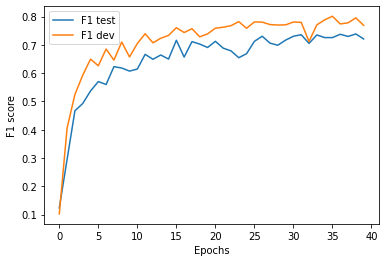

In [ ]:
plt.plot(cnn_blstm.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# Label distribution

In [ ]:
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
# array(['Amount', 'Frequency', 'Method', 'Duration', 'History'],

category_count = {"B-Amount\n": 0, "I-Amount\n":0, "B-Frequency\n": 0, "I-Frequency\n":0, "B-Method\n": 0, "I-Method\n": 0,
          "B-Duration\n": 0, "I-Duration\n":0, "B-History\n": 0, "I-History\n":0, "O": 0}
total_count = 0

for sentence in cnn_blstm.trainSentences:
    for word in sentence:
        if word[1] in category_count.keys():
            category_count[word[1]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))            

B-Amount: 13.71%
I-Amount: 18.37%
B-Frequency: 8.15%
I-Frequency: 6.58%
B-Method: 2.97%
I-Method: 0.22%
B-Duration: 7.35%
I-Duration: 15.38%
B-History: 9.06%
I-History: 18.21%
O: 0.0%


In [ ]:
cnn_blstm.trainSentences[0]

[['Social', 'O\n'],
 ['History', 'O\n'],
 [':', 'O\n'],
 ['Tob', 'O\n'],
 ['(-),', 'O\n'],
 ['EtOH', 'O\n'],
 ['-', 'O\n'],
 ['a', 'B-Amount\n'],
 ['glass', 'I-Amount\n'],
 ['of', 'O\n'],
 ['wine', 'O\n'],
 ['1-2x/month', 'B-Frequency\n'],
 [',', 'O\n'],
 ['IVDU', 'O\n'],
 ['(-),', 'O\n'],
 ['lives', 'O\n'],
 ['with', 'O\n'],
 ['her', 'O\n'],
 ['husband', 'O\n'],
 ['and', 'O\n'],
 ['9yr', 'O\n'],
 ['old', 'O\n'],
 ['daughter', 'O\n'],
 [',', 'O\n'],
 ['does', 'O\n'],
 ['not', 'O\n'],
 ['work', 'O\n'],
 ['outside', 'O\n'],
 ['of', 'O\n'],
 ['the', 'O\n'],
 ['home', 'O\n'],
 ['.', 'O\n']]

In [ ]:
from sklearn.metrics import classification_report

preds_df_analysis = pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                                     pred_df.label.result,
                                                     pred_df.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()
preds_df_analysis["prediction"].fillna( method ='ffill', inplace = True)
print (classification_report(preds_df_analysis['ground_truth'], preds_df_analysis['prediction']))


NameError: ignored

In [ ]:
from sklearn.metrics import classification_report

preds_df_analysis = pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                                     pred_df.label.result,
                                                     pred_df.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()
preds_df_analysis["prediction"].fillna( method ='ffill', inplace = True)
print (classification_report(preds_df_analysis['ground_truth'], preds_df_analysis['prediction']))